# Example ML Notebook

## Overview

Modified from AWS Academy ML Foundations Lab.

## Introduction to the business scenario

You work for a healthcare provider, and want to improve the detection of abnormalities in orthopedic patients. 

You are tasked with solving this problem by using machine learning (ML). You have access to a dataset that contains six biomechanical features and a target of *normal* or *abnormal*. You can use this dataset to train an ML model to predict if a patient will have an abnormality.


## About this dataset

This biomedical dataset was built by Dr. Henrique da Mota during a medical residence period in the Group of Applied Research in Orthopaedics (GARO) of the Centre Médico-Chirurgical de Réadaptation des Massues, Lyon, France. The data has been organized in two different, but related, classification tasks. 

The first task consists in classifying patients as belonging to one of three categories: 

- *Normal* (100 patients)
- *Disk Hernia* (60 patients)
- *Spondylolisthesis* (150 patients)

For the second task, the categories *Disk Hernia* and *Spondylolisthesis* were merged into a single category that is labeled as *abnormal*. Thus, the second task consists in classifying patients as belonging to one of two categories: *Normal* (100 patients) or *Abnormal* (210 patients).


## Attribute information

Each patient is represented in the dataset by six biomechanical attributes that are derived from the shape and orientation of the pelvis and lumbar spine (in this order): 

- Pelvic incidence
- Pelvic tilt
- Lumbar lordosis angle
- Sacral slope
- Pelvic radius
- Grade of spondylolisthesis

The following convention is used for the class labels: 
- DH (Disk Hernia)
- Spondylolisthesis (SL)
- Normal (NO) 
- Abnormal (AB)


For more information about this dataset, see the [Vertebral Column dataset webpage](http://archive.ics.uci.edu/ml/datasets/Vertebral+Column).


## Dataset attributions

This dataset was obtained from:
Dua, D. and Graff, C. (2019). UCI Machine Learning Repository (http://archive.ics.uci.edu/ml). Irvine, CA: University of California, School of Information and Computer Science.


# Lab setup

Because this solution is split across several labs in the module, you run the following cells so that you can load the data and train the model to be deployed.

**Note:** The setup can take up to 5 minutes to complete.

## Importing the data, and training, testing and validating the model

By running the following cells, the data will be imported, and the model will be trained, tested and validated and ready for use. 

**Note:** The following cells represent the key steps in the previous labs.

In order to tune the model it must be ready, then you can tweak the mdoel with hyperparameters later in step 2.

In [1]:
import time
start = time.time()
import warnings, requests, zipfile, io
warnings.simplefilter('ignore')
import pandas as pd
from scipy.io import arff

import os
import boto3
import sagemaker
from sagemaker.image_uris import retrieve
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


**Note:** The following cell takes approximately **10** minutes to complete.  Observe the code and how it processes, this will help you to better understand what is going on in the background.  The cell does the following tasks:
 - Importing the data
 - Loading the data into a dataframe
 - Splitting the data into training, test and validation datasets
 - Uploading the split datasets to S3
 - Training, testing and validating the model with the datasets

In [5]:
%%time

def plot_roc(test_labels, target_predicted_binary):
    TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()
    # Sensitivity, hit rate, recall, or true positive rate
    Sensitivity  = float(TP)/(TP+FN)*100
    # Specificity or true negative rate
    Specificity  = float(TN)/(TN+FP)*100
    # Precision or positive predictive value
    Precision = float(TP)/(TP+FP)*100
    # Negative predictive value
    NPV = float(TN)/(TN+FN)*100
    # Fall out or false positive rate
    FPR = float(FP)/(FP+TN)*100
    # False negative rate
    FNR = float(FN)/(TP+FN)*100
    # False discovery rate
    FDR = float(FP)/(TP+FP)*100
    # Overall accuracy
    ACC = float(TP+TN)/(TP+FP+FN+TN)*100

    print(f"Sensitivity or TPR: {Sensitivity}%")    
    print(f"Specificity or TNR: {Specificity}%") 
    print(f"Precision: {Precision}%")   
    print(f"Negative Predictive Value: {NPV}%")  
    print( f"False Positive Rate: {FPR}%") 
    print(f"False Negative Rate: {FNR}%")  
    print(f"False Discovery Rate: {FDR}%" )
    print(f"Accuracy: {ACC}%") 

    test_labels = test.iloc[:,0];
    print("Validation AUC", roc_auc_score(test_labels, target_predicted_binary) )

    fpr, tpr, thresholds = roc_curve(test_labels, target_predicted_binary)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

    # create the axis of thresholds (scores)
    ax2 = plt.gca().twinx()
    ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold',color='r')
    ax2.set_ylim([thresholds[-1],thresholds[0]])
    ax2.set_xlim([fpr[0],fpr[-1]])

    print(plt.figure())

def plot_confusion_matrix(test_labels, target_predicted):
    matrix = confusion_matrix(test_labels, target_predicted)
    df_confusion = pd.DataFrame(matrix)
    colormap = sns.color_palette("BrBG", 10)
    sns.heatmap(df_confusion, annot=True, fmt='.2f', cbar=None, cmap=colormap)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.show()
    

f_zip = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00212/vertebral_column_data.zip'
r = requests.get(f_zip, stream=True)
Vertebral_zip = zipfile.ZipFile(io.BytesIO(r.content))
Vertebral_zip.extractall()

data = arff.loadarff('column_2C_weka.arff')
df = pd.DataFrame(data[0])

class_mapper = {b'Abnormal':1,b'Normal':0}
df['class']=df['class'].replace(class_mapper)

cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

train, test_and_validate = train_test_split(df, test_size=0.2, random_state=42, stratify=df['class'])
test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate['class'])

prefix='lab3'

train_file='vertebral_train.csv'
test_file='vertebral_test.csv'
validate_file='vertebral_validate.csv'

s3_resource = boto3.Session().resource('s3')
my_region = boto3.session.Session().region_name # set the region of the instance

bucket = 'mlexamplegsb521' # TODO: This will have to be changed to be unique if copying this code

try:
    if  my_region == 'us-east-1':
      s3_resource.create_bucket(Bucket=bucket)
    else: 
      s3_resource.create_bucket(Bucket=bucket, CreateBucketConfiguration={ 'LocationConstraint': my_region })
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)

def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

upload_s3_csv(train_file, 'train', train)
upload_s3_csv(test_file, 'test', test)
upload_s3_csv(validate_file, 'validate', validate)

container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')

hyperparams={"num_round":"42",
             "eval_metric": "auc",
             "objective": "binary:logistic",
             "silent" : 1}

s3_output_location="s3://{}/{}/output/".format(bucket,prefix)
xgb_model=sagemaker.estimator.Estimator(container,
                                       sagemaker.get_execution_role(),
                                       instance_count=1,
                                       instance_type='ml.m5.2xlarge',
                                       output_path=s3_output_location,
                                        hyperparameters=hyperparams,
                                        sagemaker_session=sagemaker.Session())

train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file),
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

xgb_model.fit(inputs=data_channels, logs=False)

batch_X = test.iloc[:,1:];

batch_X_file='batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = xgb_model.transformer(instance_count=1,
                                       instance_type='ml.m5.2xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait(logs=False)

S3 bucket created successfully


INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-02-23-20-23-10-662



2023-02-23 20:23:12 Starting - Starting the training job..
2023-02-23 20:23:27 Starting - Preparing the instances for training.........
2023-02-23 20:24:17 Downloading - Downloading input data.........
2023-02-23 20:25:08 Training - Training image download completed. Training in progress...
2023-02-23 20:25:24 Uploading - Uploading generated training model.
2023-02-23 20:25:35 Completed - Training job completed

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-02-23-20-25-37-695


INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2023-02-23-20-25-38-325


..............................
[2023-02-23:20:30:31:INFO] No GPUs detected (normal if no gpus installed)
[2023-02-23:20:30:31:INFO] No GPUs detected (normal if no gpus installed)
[2023-02-23:20:30:31:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2023-02-23 20:30:32 +0000] [27] [INFO] Starting guni

# Step 1: Getting model statistics

Before you tune the model, re-familiarize yourself with the current model's metrics.

The setup performed a batch prediction, so you must read in the results from Amazon Simple Storage Service (Amazon S3).

In [6]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),',',names=['class'])

def binary_convert(x):
    threshold = 0.5
    if x > threshold:
        return 1
    else:
        return 0

target_predicted_binary = target_predicted['class'].apply(binary_convert)
test_labels = test.iloc[:,0]



Plot the confusion matrix and the receiver operating characteristic (ROC) curve for the original model.


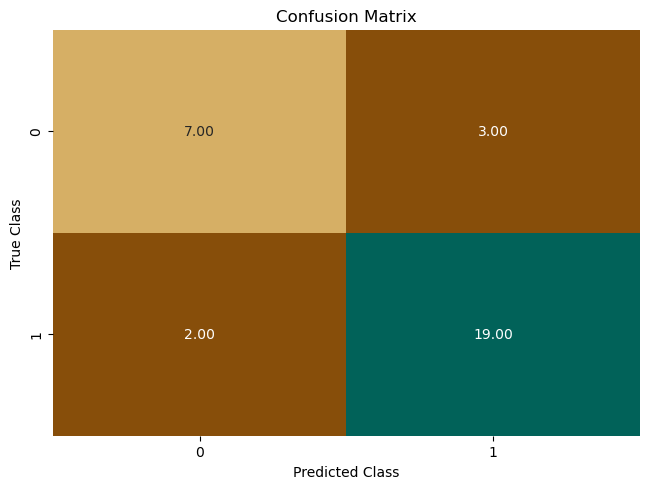

In [7]:
plot_confusion_matrix(test_labels, target_predicted_binary)

Sensitivity or TPR: 90.47619047619048%
Specificity or TNR: 70.0%
Precision: 86.36363636363636%
Negative Predictive Value: 77.77777777777779%
False Positive Rate: 30.0%
False Negative Rate: 9.523809523809524%
False Discovery Rate: 13.636363636363635%
Accuracy: 83.87096774193549%
Validation AUC 0.8023809523809523
Figure(640x480)


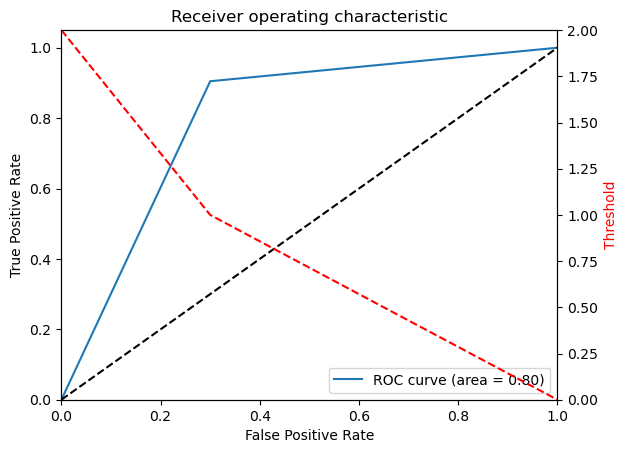

<Figure size 640x480 with 0 Axes>

In [8]:
plot_roc(test_labels, target_predicted_binary)

This plot gives you a starting point. Make a note of the *Validation area under the curve (AUC)*. You will use it later to check your tuned model to see if it's better. 

# Step 2: Creating a hyperparameter tuning job

A hyperparameter tuning job can take several hours to complete, depending on the value ranges that you provide. To simplify this task, the parameters used in this step are a subset of the recommended ranges. They were tuned to give good results in this lab, without taking multiple hours to complete.

For more information about the parameters to tune for XGBoost, see [Tune an XGBoost Model](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-tuning.html) in the AWS Documentation.

Because this next cell can take approximately **45** minutes to complete, go ahead and run the cell. You will examine what's happening, and why these hyperparameter ranges were chosen.

In [9]:
%%time
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

xgb = sagemaker.estimator.Estimator(container,
                                    role=sagemaker.get_execution_role(), 
                                    instance_count= 1, # make sure you have limit set for these instances
                                    instance_type='ml.m4.xlarge', 
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sagemaker.Session())


xgb.set_hyperparameters(eval_metric='error@.40',
                        objective='binary:logistic',
                        num_round=42)

hyperparameter_ranges = {'alpha': ContinuousParameter(0, 100),
                         'min_child_weight': ContinuousParameter(1, 5),
                         'subsample': ContinuousParameter(0.5, 1),
                         'eta': ContinuousParameter(0.1, 0.3),  
                         'num_round': IntegerParameter(1,50)
                         }

objective_metric_name = 'validation:error'
objective_type = 'Minimize'

tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=10, # Set this to 10 or above depending upon budget & available time.
                            max_parallel_jobs=1,
                            objective_type=objective_type,
                            early_stopping_type='Auto')

tuner.fit(inputs=data_channels, include_cls_metadata=False)
tuner.wait()

INFO:sagemaker:Creating hyperparameter tuning job with name: sagemaker-xgboost-230223-2031


...............................................................................................................................................................................!
!
CPU times: user 807 ms, sys: 96.8 ms, total: 904 ms
Wall time: 15min 8s


First, you will create the model that you want to tune.

```
xgb = sagemaker.estimator.Estimator(container,
                                   role=sagemaker.get_execution_role(), 
                                   instance_count= 1, # make sure you have limit set for these instances
                                   instance_type='ml.m4.xlarge', 
                                   output_path='s3://{}/{}/output'.format(bucket, prefix),
                                   sagemaker_session=sagemaker.Session())

xgb.set_hyperparameters(eval_metric='[error@.40]',
                        objective='binary:logistic',
                        num_round=42)

```                        

Notice that the *eval_metric* of the model was changed to *error@.40*, with a goal of minimizing that value. 

**error** is the binary classification error rate. It's calculated as *#(wrong cases)/#(all cases)*. For predictions, the evaluation will consider the instances that have a prediction value larger than 0.4 to be positive instances, and the others as negative instances.

Next, you must specify the hyperparameters that you want to tune, in addition to the ranges that you must select for each parameter.

The hyperparameters that have the largest effect on XGBoost objective metrics are: 

- alpha
- min_child_weight
- subsample
- eta
- num_round 

The recommended tuning ranges can be found in the AWS Documentation at [Tune an XGBoost Model](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-tuning.html).

For this lab, you will use a *subset* of values. These values were obtained by running the tuning job with the full range, then minimizing the range so that you can use fewer iterations to get better performance. Though this practice isn't strictly realistic, it prevents you from waiting several hours in this lab for the tuning job to complete.

```
hyperparameter_ranges = {'alpha': ContinuousParameter(0, 100),
                         'min_child_weight': ContinuousParameter(1, 5),
                         'subsample': ContinuousParameter(0.5, 1),
                         'eta': ContinuousParameter(0.1, 0.3),  
                         'num_round': IntegerParameter(1,50)
                         }
```


You must specify how you are rating the model. You could use several different objective metrics, a subset of which applies to a binary classifcation problem. Because the evaluation metric is **error**, you set the objective to *error*.

```
objective_metric_name = 'validation:error'
objective_type = 'Minimize'
```

Finally, you run the tuning job.

```
tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=10, # Set this to 10 or above depending upon budget & available time.
                            max_parallel_jobs=1,
                            objective_type=objective_type,
                            early_stopping_type='Auto')

tuner.fit(inputs=data_channels, include_cls_metadata=False)
tuner.wait()
```



<i class="fas fa-exclamation-triangle" style="color:red"></i> Wait until the training job is finished. It might take up to **45** minutes. While you are waiting, observe the job status in the console, as described in the following instructions.

**To monitor hyperparameter optimization jobs:**  

1. In the AWS Management Console, on the **Services** menu, choose **Amazon SageMaker**.  
2. Choose **Training > Hyperparameter tuning jobs**.  
3. You can check the status of each hyperparameter tuning job, its objective metric value, and its logs.  

After the training job is finished, check the job and make sure that it completed successfully.

In [10]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'Completed'

# Step 3: Investigating the tuning job results

Now that the job is complete, there should be 10 completed jobs. One of the jobs should be marked as the best.

You can examine the metrics by getting *HyperparameterTuningJobAnalytics* and loading that data into a pandas DataFrame.


In [11]:
from pprint import pprint
from sagemaker.analytics import HyperparameterTuningJobAnalytics

tuner_analytics = HyperparameterTuningJobAnalytics(tuner.latest_tuning_job.name, sagemaker_session=sagemaker.Session())

df_tuning_job_analytics = tuner_analytics.dataframe()

# Sort the tuning job analytics by the final metrics value
df_tuning_job_analytics.sort_values(
    by=['FinalObjectiveValue'],
    inplace=True,
    ascending=False if tuner.objective_type == "Maximize" else True)

# Show detailed analytics for the top 20 models
df_tuning_job_analytics.head(20)


,alpha,eta,min_child_weight,num_round,subsample,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
2,7.267462,0.162105,1.422175,44.0,0.559679,sagemaker-xgboost-230223-2031-008-6c93ae34,Completed,0.09677,2023-02-23 20:44:01+00:00,2023-02-23 20:44:34+00:00,33.0
5,11.612633,0.163354,4.116106,28.0,0.784667,sagemaker-xgboost-230223-2031-005-cb8ca36e,Completed,0.09677,2023-02-23 20:40:59+00:00,2023-02-23 20:41:36+00:00,37.0
1,9.379058,0.159748,2.300535,11.0,0.558327,sagemaker-xgboost-230223-2031-009-15d6f28d,Completed,0.12903,2023-02-23 20:44:49+00:00,2023-02-23 20:45:22+00:00,33.0
3,0.000000,0.174891,1.000000,49.0,0.678499,sagemaker-xgboost-230223-2031-007-437bf68a,Completed,0.12903,2023-02-23 20:42:54+00:00,2023-02-23 20:43:44+00:00,50.0
0,18.130075,0.299612,1.046529,1.0,0.941216,sagemaker-xgboost-230223-2031-010-9caabd72,Completed,0.22581,2023-02-23 20:45:39+00:00,2023-02-23 20:46:07+00:00,28.0
7,22.985185,0.248663,3.517084,49.0,0.885029,sagemaker-xgboost-230223-2031-003-b5a75697,Completed,0.22581,2023-02-23 20:37:32+00:00,2023-02-23 20:39:25+00:00,113.0
4,60.525761,0.173054,2.836423,7.0,0.806390,sagemaker-xgboost-230223-2031-006-5cec2978,Completed,0.67742,2023-02-23 20:41:56+00:00,2023-02-23 20:42:33+00:00,37.0
6,82.021957,0.276976,4.637002,49.0,0.604031,sagemaker-xgboost-230223-2031-004-f7f8a06b,Stopped,0.67742,2023-02-23 20:40:16+00:00,2023-02-23 20:40:41+00:00,25.0
8,45.096671,0.226297,2.829618,46.0,0.526593,sagemaker-xgboost-230223-2031-002-b087f4b5,Stopped,0.67742,2023-02-23 20:35:19+00:00,2023-02-23 20:35:40+00:00,21.0
9,67.472798,0.217553,4.539316,21.0,0.583416,sagemaker-xgboost-230223-2031-001-84767abe,Completed,0.67742,2023-02-23 20:33:07+00:00,2023-02-23 20:34:56+00:00,109.0


You should be able to see the hyperparameters that were used for each job, along with the score. You could use those parameters and create a model, or you can get the best model from the hyperparameter tuning job.

In [12]:
attached_tuner = HyperparameterTuner.attach(tuner.latest_tuning_job.name, sagemaker_session=sagemaker.Session())
best_training_job = attached_tuner.best_training_job()

Now, you must attach to the best training job and create the model.

In [13]:
from sagemaker.estimator import Estimator
algo_estimator = Estimator.attach(best_training_job)

best_algo_model = algo_estimator.create_model(env={'SAGEMAKER_DEFAULT_INVOCATIONS_ACCEPT':"text/csv"})


2023-02-23 20:42:52 Starting - Found matching resource for reuse
2023-02-23 20:42:52 Downloading - Downloading input data
2023-02-23 20:42:52 Training - Training image download completed. Training in progress.
2023-02-23 20:42:52 Uploading - Uploading generated training model
2023-02-23 20:42:52 Completed - Resource reused by training job: sagemaker-xgboost-230223-2031-007-437bf68a


Then, you can use the transform method to perform a batch prediction by using your testing data. Remember that the testing data is data that the model has never seen before.

In [14]:
%%time
batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = best_algo_model.transformer(instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)


xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait(logs=False)

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-02-23-20-46-31-533
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2023-02-23-20-46-32-085


.....................................[2023-02-23:20:52:34:INFO] No GPUs detected (normal if no gpus installed)
[2023-02-23:20:52:34:INFO] No GPUs detected (normal if no gpus installed)
[2023-02-23:20:52:34:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2023-02-23 20:52:34 +0000] [18] [INFO] Startin

Get the predicted target and the test labels of the model.

In [15]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
best_target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),',',names=['class'])

def binary_convert(x):
    threshold = 0.5
    if x > threshold:
        return 1
    else:
        return 0

best_target_predicted_binary = best_target_predicted['class'].apply(binary_convert)
test_labels = test.iloc[:,0]

Plot a confusion matrix for your `best_target_predicted` and `test_labels`.

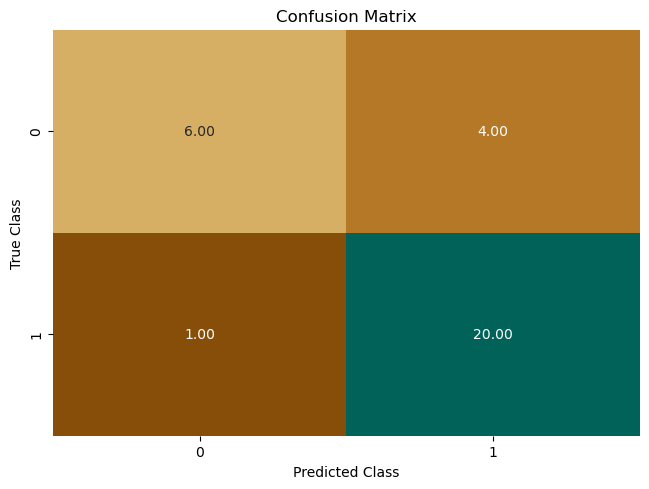

In [16]:
plot_confusion_matrix(test_labels, best_target_predicted_binary)

Plot the ROC chart.

Sensitivity or TPR: 95.23809523809523%
Specificity or TNR: 60.0%
Precision: 83.33333333333334%
Negative Predictive Value: 85.71428571428571%
False Positive Rate: 40.0%
False Negative Rate: 4.761904761904762%
False Discovery Rate: 16.666666666666664%
Accuracy: 83.87096774193549%
Validation AUC 0.7761904761904761
Figure(640x480)


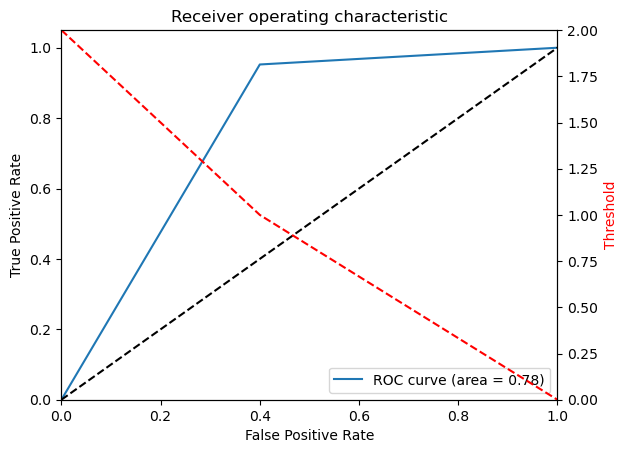

<Figure size 640x480 with 0 Axes>

In [17]:
plot_roc(test_labels, best_target_predicted_binary)

**Question:** How do these results differ from the original? Are these results better or worse? 

You might not always see an improvement. There are a few reasons for this result:

- The model might already be good from the initial pass (what counts as *good* is subjective).
- You don't have a large amount of data to train with.
- You are using a *subset* of the hyperparameter tuning ranges to save time in this lab.

Increasing the hyperparameter ranges (as recommended by the documentation) and running more than 30 jobs will typically improve the model. However, this process will take 2-3 hours to complete.